In [31]:
%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Texas Interconnect IDF Curves

In this notebook we will look at the return period of the aggregate temperature excursion from 68F (a proxy for heating demand!) over the part of Texas that is in the Texas Interconnect (TI).

In [32]:
from labellines import labelLines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import regionmask
from scipy.stats import genextreme as gev
import xarray as xr

from codebase.calc import calc_plotposition_return_level, calc_mle_return_level
from codebase.fig import smart_save, add_panel_text
from codebase.path import datadir, figdir

In [33]:
hdd = xr.open_dataset(datadir("processed", "era5", "tx", "hdd_ercot.nc"))
hdd

<xarray.Dataset>
Dimensions:        (time: 181944, pop_year: 5)
Coordinates:
  * time           (time) datetime64[ns] 1940-01-01 ... 2023-12-31T23:00:00
  * pop_year       (pop_year) int64 2000 2005 2010 2015 2020
Data variables:
    pop_weighted   (time, pop_year) float64 ...
    area_weighted  (time) float64 ...

This data contains area averages over the Texas Interconnect

## IDF Curves

We're going to construct IDF Curves for several data sets.
First, we will need to compute the HDD at various lags.
Our data is hourly

In [34]:
DURATIONS = np.concatenate(
    [range(1, 4), range(4, 13, 2), range(12, 21, 4), range(24, 121, 8)]
)
DURATIONS = np.unique(DURATIONS)
DURATIONS

array([  1,   2,   3,   4,   6,   8,  10,  12,  16,  20,  24,  32,  40,
        48,  56,  64,  72,  80,  88,  96, 104, 112, 120])

In [35]:
hdd_roll = xr.concat(
    [
        hdd.rolling(time=duration).mean().assign_coords({"duration": duration})
        for duration in DURATIONS
    ],
    dim="duration",
)

Next we will construct annual maximum time series

In [36]:
# group together December YYYY and Jan YYYY+1
times = pd.to_datetime(hdd_roll["time"].values)
year_eff = times.year + np.int_(times.month > 7)
hdd_roll["year_eff"] = xr.DataArray(
    year_eff, coords={"time": hdd_roll["time"]}, dims="time"
)

In [37]:
hdd_annual = hdd_roll.groupby("year_eff").max(dim="time").sel(year_eff=slice(0, 2023))
hdd_annual

<xarray.Dataset>
Dimensions:        (pop_year: 5, year_eff: 84, duration: 23)
Coordinates:
  * pop_year       (pop_year) int64 2000 2005 2010 2015 2020
  * duration       (duration) int64 1 2 3 4 6 8 10 ... 72 80 88 96 104 112 120
  * year_eff       (year_eff) int64 1940 1941 1942 1943 ... 2020 2021 2022 2023
Data variables:
    pop_weighted   (year_eff, duration, pop_year) float64 46.77 46.75 ... 32.26
    area_weighted  (year_eff, duration) float64 48.89 48.69 48.47 ... 33.5 32.73

We'd like to make sure the raw data that will go into these plots is available to anyone else who wants to see it.

In [38]:
hdd_annual.to_netcdf(datadir("outputs", "hdd_annual_ercot.nc"))

### Plotting

If you're going through, note that we add + year to events in December, so that the Dec 1989 event is coded as winter 1990.

In [39]:
RETURN_PERIODS = [2, 5, 10, 25, 50, 100]
STORM_YEARS = [1951, 1962, 1984, 1990, 2011, 2021]
STORM_LABELS = [
    "Feb. 1951",
    "Jan. 1962",
    "Dec. 1983",
    "Dec. 1989",
    "Feb. 2011",
    "Feb. 2021",
]

Next we define some tuples of stuff to plot.
The first is the time series to plot, the second is the function to use, and the third is the filename.

In [40]:
plot_info = [
    [
        hdd_annual["pop_weighted"].sel(pop_year=2020),
        calc_mle_return_level,
        "ERCOT_HDD_IDF_MLE_popweighted",
    ],
    [
        hdd_annual["area_weighted"],
        calc_mle_return_level,
        "ERCOT_HDD_IDF_MLE_unweighted",
    ],
    [
        hdd_annual["pop_weighted"].sel(pop_year=2020),
        calc_plotposition_return_level,
        "ERCOT_HDD_IDF_plotpos_popweighted",
    ],
    [
        hdd_annual["area_weighted"],
        calc_plotposition_return_level,
        "ERCOT_HDD_IDF_plotpos_unweighted",
    ],
]

Now we build the plot

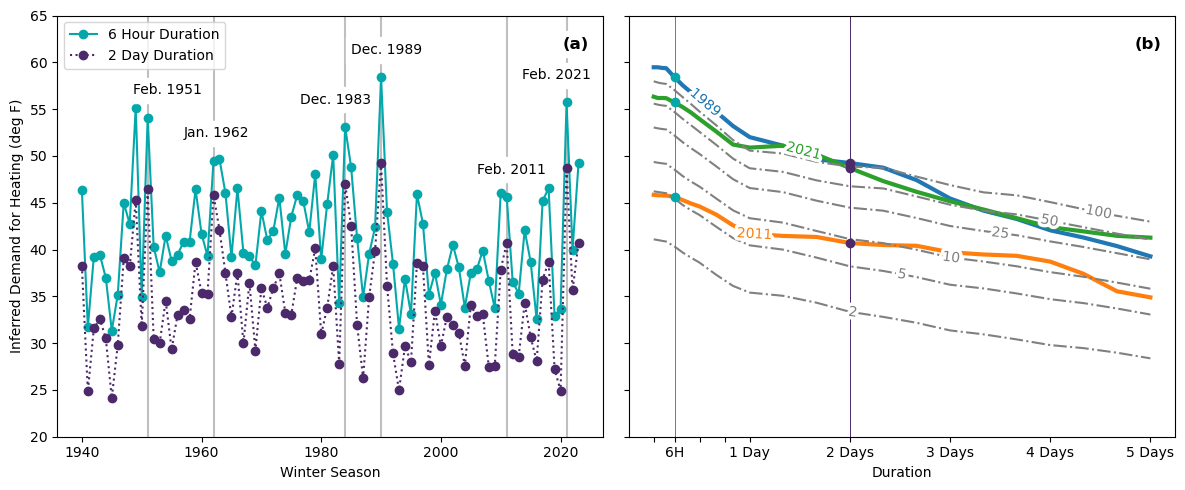

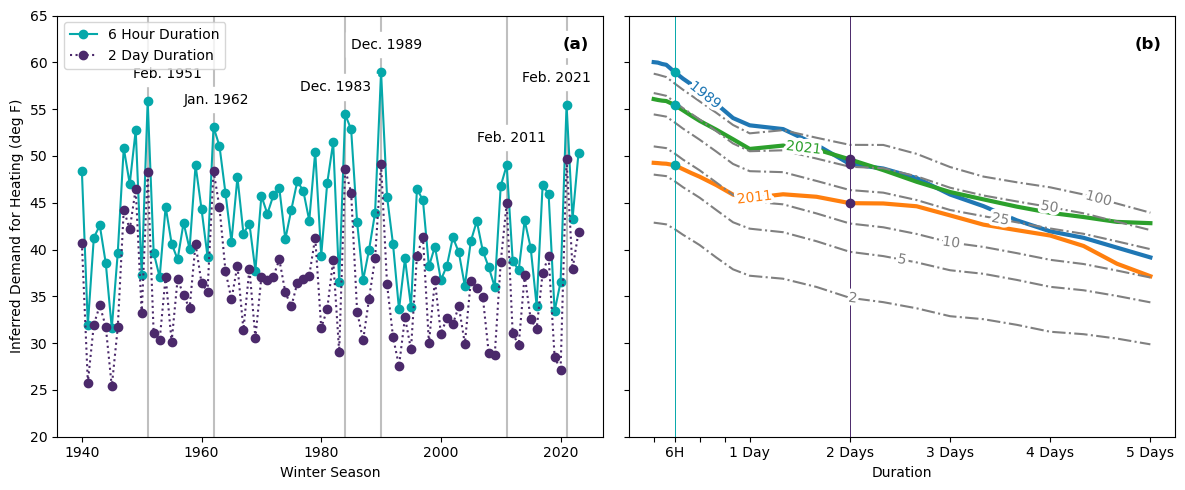

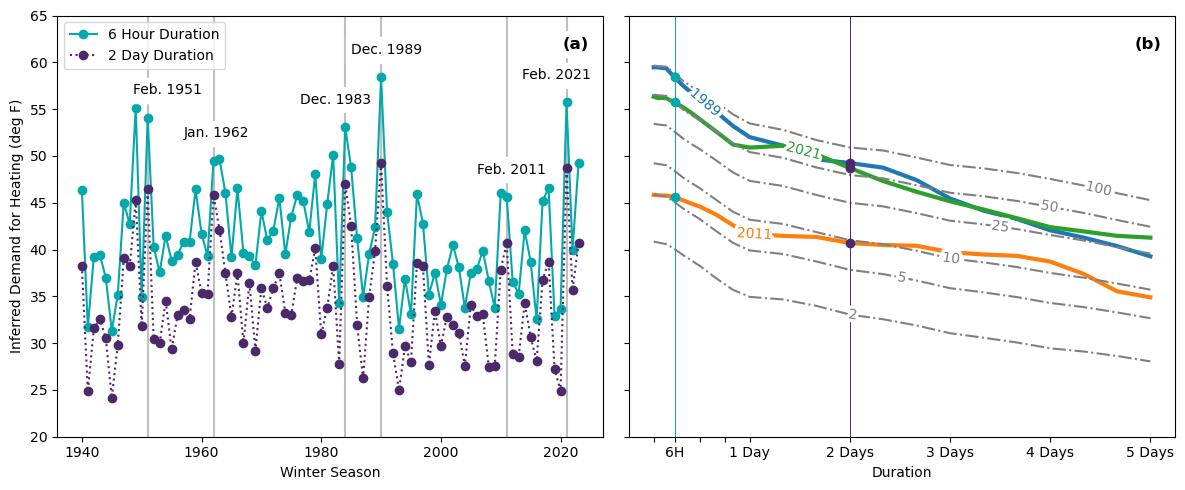

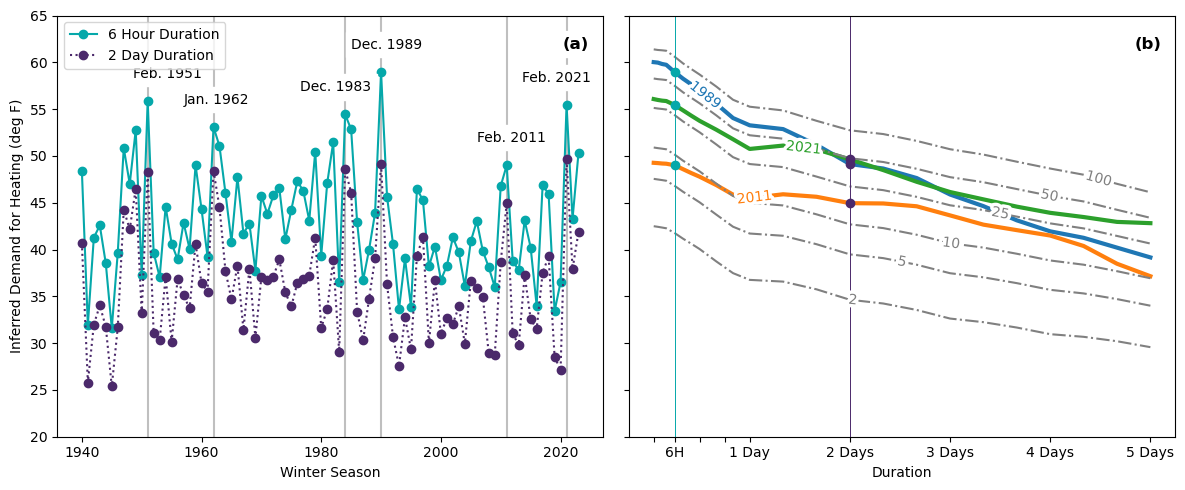

In [41]:
for obs, return_level, fname in plot_info:

    fig, axes = plt.subplots(
        nrows=1, ncols=2, figsize=(12, 5), sharey=True, sharex=False
    )

    # Plot Time Series
    ax = axes[0]

    # add pointers to events referenced in the text
    for storm_year, storm_name, xshift in zip(
        STORM_YEARS,
        STORM_LABELS,
        [-2.5, -5, -7.5, -5, -5, -7.5],
    ):
        storm_y = obs.sel(duration=6, year_eff=storm_year)
        ax.axvline(storm_year, c="gray", alpha=0.5)
        ax.annotate(
            storm_name,
            xy=(storm_year, storm_y),
            xytext=(storm_year + xshift, storm_y + 2.5),
            backgroundcolor="white",
        )

    obs.sel(duration=6).plot(
        ax=ax, label="6 Hour Duration", color="#05A8AA", marker="o"
    )
    obs.sel(duration=48).plot(
        ax=ax, label="2 Day Duration", color="#4B296B", linestyle=":", marker="o"
    )
    ax.set_ylabel("Inferred Demand for Heating (deg F)")
    ax.legend(loc="upper left")
    ax.set_title("")
    ax.set_xlabel("Winter Season")
    ax.set_ylim([20, 65])  # for consistency

    # Plot IDF CURVE
    ax = axes[1]
    obs.sel(year_eff=1990).plot(
        ax=ax, label="1989", linewidth=3
    )  # Dec 1989 is coded as 1990 here
    obs.sel(year_eff=2011).plot(ax=ax, label="2011", linewidth=3)
    obs.sel(year_eff=2021).plot(ax=ax, label="2021", linewidth=3)
    for rp in RETURN_PERIODS:
        ax.plot(
            DURATIONS,
            [
                return_level(
                    X=obs.sel(duration=duration, year_eff=slice(0, 2020)).values, T=rp
                )
                for duration in DURATIONS
            ],
            label=rp,
            color="gray",
            linestyle="-.",
        )

    labelLines(ax.get_lines(), zorder=2.5)

    # dots to correspand with panel (a)
    for duration, color in zip([6, 48], ["#05A8AA", "#4B296B"]):
        for year_eff in [1990, 2011, 2021]:
            ax.plot(
                duration,
                float(obs.sel(duration=duration, year_eff=year_eff)),
                color=color,
                marker="o",
            )
            ax.axvline(duration, color=color, linewidth=0.5)

    ax.set_xlabel("Duration")
    ax.set_xticks([1, 6, 12, 18, 24, 48, 72, 96, 120])
    ax.set_xticklabels(
        ["", "6H", "", "", "1 Day", "2 Days", "3 Days", "4 Days", "5 Days"]
    )
    ax.set_title("")
    ax.set_ylabel("")

    add_panel_text(
        axes,
        backgroundcolor="white",
        fontsize=12,
    )
    # Add  color bars

    fig.subplots_adjust(top=0.925)

    fig.canvas.draw()
    fig.tight_layout()
    smart_save(fname)
    plt.show()

We can see here that December 1989 was more severe by most measures than 2021, but that 2011 was far less severe.
Now let's use just one data set to quantify precisely how many years were within 90% of 2021

In [42]:
for dur in [6, 24, 48]:
    comparable_events = hdd_annual.sel(pop_year=2020, duration=dur) > (
        0.9
        * hdd_annual.sel(
            year_eff=2021,
            pop_year=2020,
            duration=dur,
        )
    )
    comparable_events = comparable_events["pop_weighted"]
    hdd_top = comparable_events.sel(year_eff=comparable_events)
    print(f"{dur} hours:\n", hdd_top)

6 hours:
 <xarray.DataArray 'pop_weighted' (year_eff: 5)>
array([ True,  True,  True,  True,  True])
Coordinates:
    pop_year  int64 2020
    duration  int64 6
  * year_eff  (year_eff) int64 1949 1951 1984 1990 2021
24 hours:
 <xarray.DataArray 'pop_weighted' (year_eff: 6)>
array([ True,  True,  True,  True,  True,  True])
Coordinates:
    pop_year  int64 2020
    duration  int64 24
  * year_eff  (year_eff) int64 1949 1951 1962 1984 1990 2021
48 hours:
 <xarray.DataArray 'pop_weighted' (year_eff: 6)>
array([ True,  True,  True,  True,  True,  True])
Coordinates:
    pop_year  int64 2020
    duration  int64 48
  * year_eff  (year_eff) int64 1949 1951 1962 1984 1990 2021


The historic events in February 1951, December 1983 (classified here as 1984 because December years are grouped with the following Jan-Feb), January 1962, and December 1989 created at least 90% as much per-capita demand for heating as the February 2021 event over a 24 hour duration.

### Blog version

Finally, let's create a version of the plot using the population-weighted MLE approach with only the time series for easy dissemination.

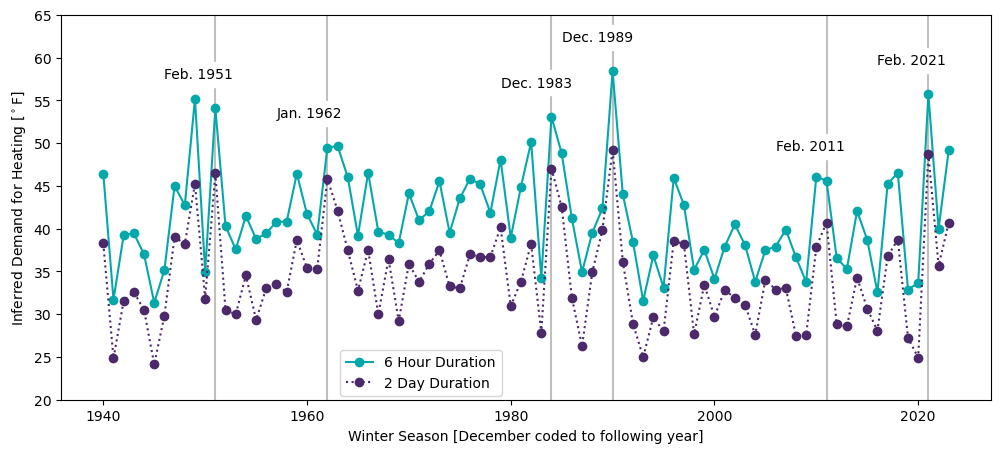

In [43]:
obs, return_level, fname = (
    hdd_annual["pop_weighted"].sel(pop_year=2020),
    calc_mle_return_level,
    "ERCOT_HDD_blog",
)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 5), sharey=True, sharex=False)


# add pointers to events referenced in the text
for storm_year, storm_name, xshift in zip(
    STORM_YEARS,
    STORM_LABELS,
    [-5, -5, -5, -5, -5, -5],
):
    storm_y = obs.sel(duration=6, year_eff=storm_year)
    ax.axvline(storm_year, c="gray", alpha=0.5)
    ax.annotate(
        storm_name,
        xy=(storm_year, storm_y),
        xytext=(storm_year + xshift, storm_y + 3.5),
        backgroundcolor="white",
    )

obs.sel(duration=6).plot(ax=ax, label="6 Hour Duration", color="#05A8AA", marker="o")
obs.sel(duration=48).plot(
    ax=ax, label="2 Day Duration", color="#4B296B", linestyle=":", marker="o"
)
ax.set_ylabel("Inferred Demand for Heating [$^\circ$F]")
ax.legend(loc=(0.3, 0.01))
ax.set_title("")
ax.set_xlabel("Winter Season [December coded to following year]")
ax.set_ylim([20, 65])  # for consistency


smart_save(fname)
plt.show()

## Technical Aside

One other interesting point to note: this may seem counterintuitive

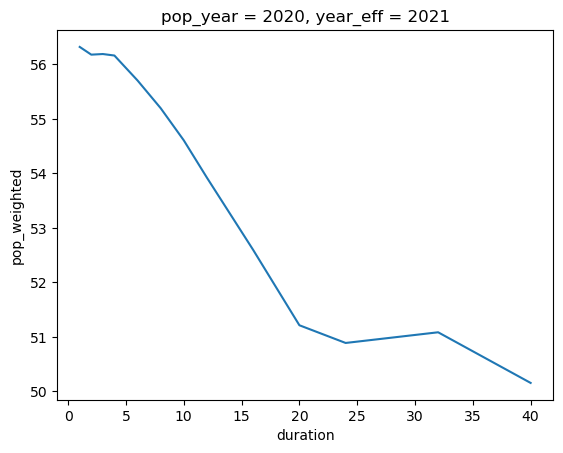

In [44]:
hdd_annual["pop_weighted"].sel(
    year_eff=2021, pop_year=2020, duration=slice(0, 40)
).plot()
plt.show()

See that dip?
It doesn't seem like it should make sense because what it is effectively saying is that the average temperature is colder if you average over 30 hours than if you average over 24 hours.
But it's not a mistake!

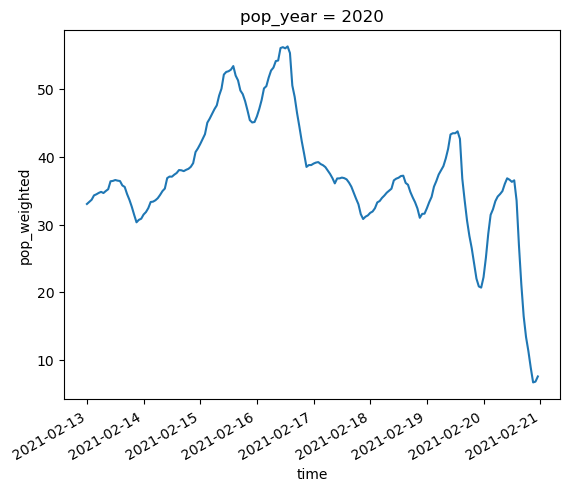

In [45]:
hdd["pop_weighted"].sel(pop_year=2020, time=slice("2021-02-13", "2021-02-20")).plot()
plt.show()

There's a diurnal cycle causing two peaks.
Averaging over a longer time lets you capture both of the peaks.
Thus, this isn't a mistake in the data.
It looks pretty weird on the IDF curve, though!